In [490]:
import pandas as pd
import numpy as np
from scipy.special import logsumexp
from sklearn.model_selection import GroupShuffleSplit 
from models import utils
from models import mace, latent_annotator_clustering
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score

In [491]:
train_df = pd.read_csv('./data/SBIC.v2/SBIC.v2.trn.csv',delimiter=',', encoding='latin-1')
train_df = train_df.dropna(subset=['offensiveYN'])
annotator_df = train_df[['WorkerId','annotatorPolitics','annotatorRace','annotatorAge','annotatorGender']].drop_duplicates().dropna()


In [492]:
#drop all the rows with any  "na" values in annotator_df
annotator_df = annotator_df[annotator_df.annotatorPolitics != "na"]
annotator_df = annotator_df[annotator_df.annotatorRace != "na"]
annotator_df = annotator_df[annotator_df.annotatorAge != "na"]
annotator_df = annotator_df[annotator_df.annotatorGender != "na"]


In [493]:
len(train_df), len(annotator_df)

(110883, 343)

In [494]:
len(annotator_df["WorkerId"].unique().tolist()), len(annotator_df["WorkerId"].tolist())

(248, 343)

In [496]:
# remove annotators that have annotated more than once with different demographics
annotator_df = annotator_df[annotator_df["WorkerId"].isin(annotator_df["WorkerId"].value_counts()[annotator_df["WorkerId"].value_counts() <= 1].index.tolist())]
# create age groups for annotators and replace the age with the age group
age_groups = ['18-24','25-34','35-44','45-54','55-64','65-74','75+']
annotator_df['annotatorAge'] = pd.cut(annotator_df.annotatorAge.astype(int), bins=[18, 24, 34, 44, 54, 64, 74, 101], labels=age_groups, right=False)


In [497]:
# drop all the rows in train_df where the workerid is not in annotator_df
train_df = train_df[train_df.WorkerId.isin(annotator_df.WorkerId)]

#remove all columns except for the ones that are in the annotator_df but keep the workerid column
train_df = train_df[['WorkerId','post', 'offensiveYN', 'HITId']].drop_duplicates()

In [498]:
train_df.offensiveYN.value_counts()

0.0    14856
1.0    12536
0.5     3262
Name: offensiveYN, dtype: int64

In [499]:
sentiment_labels = [0, 0.5, 1]#['Not offensive','Somewhat offensive','Offensive']
annotator_ids = annotator_df["WorkerId"].unique().tolist()

id2label = {index: row for (index, row) in enumerate(sentiment_labels)} 
label2id = {row: index for (index, row) in enumerate(sentiment_labels)}

id2annotator = {index: row for (index, row) in enumerate(annotator_ids)}
annotator2id = {row: index for (index, row) in enumerate(annotator_ids)}

train_df['annotator_id'] = train_df.WorkerId.map(annotator2id)
train_df['annotation'] = train_df.offensiveYN.map(label2id)
annotator_df['annotator_id'] = annotator_df.WorkerId.map(annotator2id)


In [500]:
pivot_df = pd.pivot_table(
    train_df,
    values='annotation',
    index='HITId',
    columns='annotator_id', 
    # aggfunc=lambda x: ''.join(x) # Concatenate multiple annotations if they exist for a single unit/annotator pair
)

pivot_df = pivot_df.fillna(-1)
pivot_df.index.name = None
pivot_df.columns.name = None



In [501]:
len(pivot_df)

22849

In [502]:
train_df.HITId.unique().shape

(22849,)

In [503]:
set1 = set(train_df.HITId.unique())
set2 = set(pivot_df.index.unique())

set3 = set1 - set2

In [580]:
data = list()

# Iterate over the rows of the DataFrame
for index, row in pivot_df.iterrows():
    data.append(list())
    for a in row.index:
    # Extract the annotator and annotation values from the row
        annotator = a
        annotation = int(row[a])
        # print(annotator, annotation)
        if(annotation  != -1):
        # Append the (annotator, annotation) pair to the data list
            data[-1].append((annotator, annotation))

In [505]:
A_ls, B_ls, C_ls, elbos_ls = latent_annotator_clustering.evaluate(data, len(train_df["annotation"].unique()), len(train_df["annotator_id"].unique()), 2, 300,15, smoothing=True, logspace=True)

In [511]:
clusters = B_ls.argmax(axis=1)

<Axes: xlabel='Cluster'>

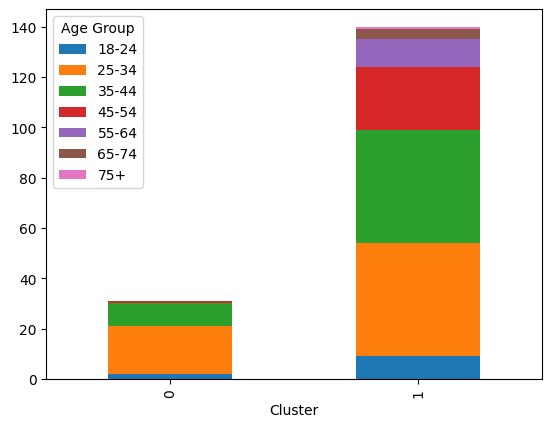

In [512]:
data = pd.DataFrame({'Cluster': clusters, 'Age Group': annotator_df["annotatorAge"]})
grouped_data = data.groupby(['Cluster', 'Age Group']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Cluster', columns='Age Group', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Cluster'>

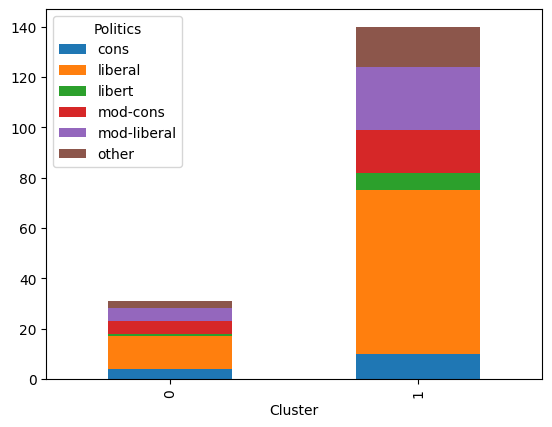

In [513]:
data = pd.DataFrame({'Cluster': clusters, 'Politics': annotator_df["annotatorPolitics"]})
grouped_data = data.groupby(['Cluster', 'Politics']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Cluster', columns='Politics', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Cluster'>

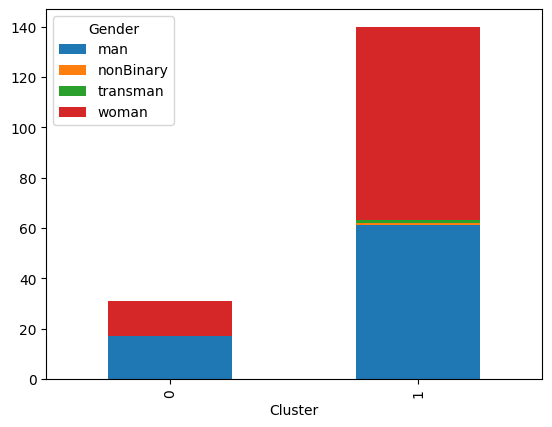

In [514]:
data = pd.DataFrame({'Cluster': clusters, 'Gender': annotator_df["annotatorGender"]})
grouped_data = data.groupby(['Cluster', 'Gender']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Cluster', columns='Gender', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Cluster'>

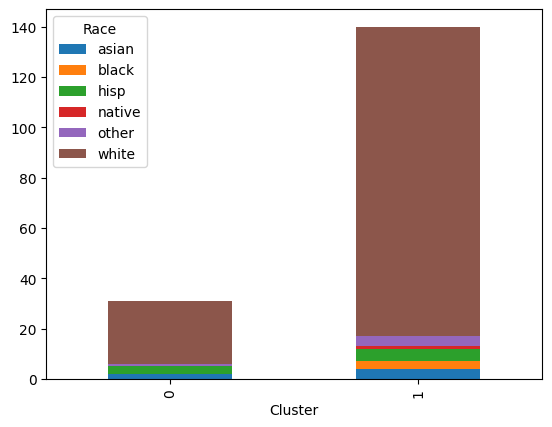

In [515]:
data = pd.DataFrame({'Cluster': clusters, 'Race': annotator_df["annotatorRace"]})
grouped_data = data.groupby(['Cluster', 'Race']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Cluster', columns='Race', values='Count')
pivot_table.plot(kind='bar', stacked=True)